In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline

We start with a linear model of the system

In [2]:
nMV = 2
nCV = 2
G11 = scipy.signal.lti([-10], [15, 1]) # reflux to top , first digit indicates CV and second dight indicates MV
G21 = scipy.signal.lti([-5], [30,1]) # reflux to bottom 
G12 = scipy.signal.lti([0.05],[2,1]) # reboiler to bottom
G22 = scipy.signal.lti([0.02],[5,1]) # reboiler to top.
K = numpy.array([-10,-5,0.05,0.02]).reshape(2,2) # MVs are across the columns, CVs across the rows


In [3]:
M = 18  # Control horizon
P = 72  # Prediction horizon

In [4]:
DeltaT = 1  # Sampling rate

In [5]:
tcontinuous = numpy.linspace(0, DeltaT*P, 1000)  # some closely spaced time points
tpredict = numpy.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon


reshape(-1,1) changes the array shape from horizontal to vertical

In [6]:
ABSU = numpy.array([50,2000]).reshape(-1,1)
U= numpy.ones(nMV).reshape(-1,1) # initial move 
ABSY0 = numpy.array([100,20]).reshape(-1,1) # initial value of top purity.
ABSYSP = numpy.array([120,25]).reshape(-1,1) # desired target entered by the user. 
YSP = ABSYSP -ABSY0 # desired deviation 


In [7]:
x1 = numpy.zeros(G11.A.shape[0])
x2= numpy.zeros(G21.A.shape[0])


In [8]:
Q= numpy.array([1,2]).reshape(-1,1) # CV Weight 
R= numpy.array([10,2]) # MV Weight 

In [9]:
YSS = numpy.dot(K ,U)


In [10]:
#The steady state solver takes the MV array , CV set targets array, CV deviations  and the  gain matrix and should return the steady state targets .
def steadystateobjective(U):
    YSS = numpy.dot(K,U)
    SummedError = numpy.sum(numpy.abs((YSP - YSS)*Q)) # weighted error sum
    return SummedError

USS_row = scipy.optimize.minimize(steadystateobjective, U).x # not sure , why this .x
USS = USS_row.reshape(-1,1)
YSS = numpy.dot(K,USS)
ABSUSS = ABSU + USS
ABSYSS = ABSY0+ YSS
#YSPRef = YSS*numpy.ones(P) # desired trajectory 
ABSUSS,ABSYSS
USS,YSS,ABSUSS,ABSYSS

(array([[-0.59628645],
        [ 0.1925729 ]]), array([[ 5.00000002],
        [-0.02596286]]), array([[   49.40371355],
        [ 2000.1925729 ]]), array([[ 105.00000002],
        [  19.97403714]]))

In [11]:
USS

array([[-0.59628645],
       [ 0.1925729 ]])

In [12]:
#u = USS*numpy.ones(M) # u is an array of length  M ( control horizon ) , that holds the MV move plan , initially set to the steady state move
U = numpy.zeros((nMV,M))
U

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

The following code extracts the last column and repeats for 10 times.

this can also be achieved by tiles as below , U[:,-1] extracts the last column , but returns as a row. To keep it as column , use transpose . and then give the shape (10 rows 1 column )to be tiled

the following cell shows how to stack the array horizontally.

In [13]:
# this function repeats holds the last move of the controller steady , from the current time , until control horizon
def extend(u):
    return numpy.hstack((u, np.tile(u[:,-1].transpose(),(nMV,(P-M)))))
extend(U)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In the above cell, i have been trying to repeat the last column of the 2D array U


def prediction(u, t=tpredict, x0=0):
    t, y1, x1 = scipy.signal.lsim(G11, u, t,  interp=False)
    t, y2, x2 = scipy.signal.lsim(G21, u, t,  interp=False)
    return y1,y2

should the objective include enforcement of MV steady state values , or is it decided automatically by the CV trajecetory reference?


one thing that i need to look clearly is , where to put the A matrix elements. Remember all the state vectors , input vectors and output vector are column vectors. when we perform on operation , the result ( for example , the Xdot , vector ) should also be the same size as the state vector. But A matrix size is n x n . So if the X vector consists of X1 and X2 states, So I think, the first row of A matrix should be the coefficients for X1 and the second row for state matrix should be for X2. 

In [14]:

A = np.array([[-1/15, 0],
            [0, -1/5]])
B = np.array([[-0.1, 0.2], 
            [-0.3,-0.2]])
C = np.array([[1, 0],[0,1]])


In [27]:
x = np.zeros((nCV,1)) # state vector
ys = np.zeros((nCV,P)) # prediction matrix

In [28]:
ts = numpy.linspace(0, P, P)
dt = ts[1]

def u(t):
    if t < 0:
        return np.array([0,0]).transpose()
    else:
        return np.array([1,1]).transpose()
 



In [29]:
B.dot(u(1))

array([ 0.1, -0.5])

In [30]:
for i,t in enumerate(ts):
    dxdt = A.dot(x) + B.dot(u(t))
    y = C.dot(x) # output vector
    x = x + dxdt*dt
    ys[:,i] = y[:,0] # this assigns the ith column of a numpy array to another vect

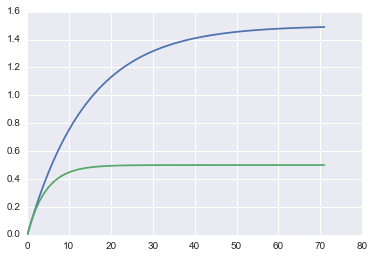

In [31]:
for i in range(2):
    plt.plot(ys[i])

In [20]:
def objective(u):
    YC1,YC2 = prediction(extend(u))
    YC = numpy.vstack((YC1,YC2)) # note the one argument given within double brackets.
    return numpy.sum((Q*(YC-YSPRef))**2) + numpy.sum ((numpy.ediff1d(u, to_begin=u[0])*R)**2)

Now we figure out a set of moves which will minimise our objective function

one thing i fail to understand , why the MV starts from negative values. but the deviation CVs (rightly ) reach from the 0 , and reach the steady state values. But MVs on the other hand , even though they reach the steady state values, there is an "initial kick" in the first move , i think it is because , the first move is not penalized  due to the nature of numpy.diff function that it starts differencing from second element. . As a result there is an overshoot. ok. after I changed from diff to ediff1d , the 

In [21]:
uopt = scipy.optimize.minimize(objective, u).x
uopt


NameError: name 'prediction' is not defined

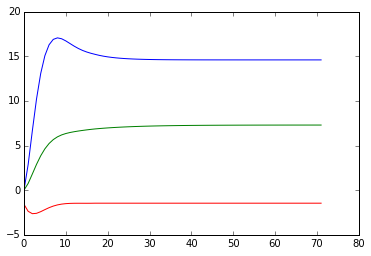

In [90]:
opt1,opt2 = prediction(extend(uopt))
plt.plot(opt1)
plt.plot(opt2)
plt.plot(extend(uopt))

Resample the discrete output to continuous time

Plot the move plan and the output. Notice that we are getting exactly the output we want at the sampling times.

NameError: name 'ucont' is not defined

ValueError: x and y must have same first dimension

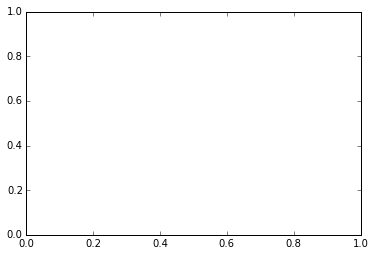

In [71]:
plt.plot(tcontinuous, prediction(ucont, tcontinuous))         

### things to do
1. develop a steadystate solver that calculates the steady state targets
inputs:
    . model
    . initial conditions of MV 
    . initial conditions of CVs
    . CV targets. 
    . CV priorities. 
    . CV Weights. 
  ouputs
  . CV targets
  . MV Targets
 2. devleop constrained optimizer.  ( max move constraints, vavle position constraints)
 3. estimate state using kalman 
 
 
 Flow chart 
 1. calculate the set of optimal moves 
 2. implement the first move
 3. implement the state estimator 
 4. update the predictions, calculate the new set of moves
 5.